# Imports



In [ ]:
%pip install sentence_transformers

In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid', palette='deep')

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sentence_transformers import SentenceTransformer
from transformers import TFAutoModel, AutoTokenizer
import tensorflow_hub as hub

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
'''
Tokenisation avec normalisation, suppression des stopwords,
filtrage en fonction de la longeur, suppression des chiffres
'''
def tokenize(doc, min_lenght, no_numeric):
  # Tout en minuscule
  doc = doc.lower().strip()
  # Tokenisation en excluant la ponctuation et les stopwords
  tokenizer = nltk.RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(doc)

  sw = set()
  sw.update(tuple(nltk.corpus.stopwords.words('english')))
  cleaned_tokens = [w for w in tokens if not w in list(sw)]
  # Supprimer les tokens de longueur inférieure à min_lenght
  more_than_n = [w for w in cleaned_tokens if len(w)>=min_lenght]
  # Supprimer les tokens numériques si demandé
  if no_numeric:
    alpha_tokens = [w for w in more_than_n if w.isalpha()]
  else:
    alpha_tokens = more_than_n
  return alpha_tokens
'''
Stemming d'un seul document pour tester
'''
def stem_one(df, feature):
  ps = PorterStemmer()
  for i in range(len(df.iloc[0, df.columns.get_loc(feature)])):
    df.iloc[0, df.columns.get_loc(feature)][i] = ps.stem(df.iloc[0, df.columns.get_loc(feature)][i])
'''
Lemmatiser chaque mot de chaque document
'''
def lemmatize(df, feature):
  lemmatizer = WordNetLemmatizer()
  for j in range(df.shape[0]):
    for i in range(len(df.iloc[j, df.columns.get_loc(feature)])):
      df.iloc[j, df.columns.get_loc(feature)][i] = lemmatizer.lemmatize(df.iloc[j, df.columns.get_loc(feature)][i])
'''
Réduction de dimensions : TSNE
'''
def X_tsne(features):
  return pd.DataFrame(TSNE(n_components=2, perplexity=30, n_iter=2000).fit_transform(features))
'''
Visulaisation de la projection 2D de TSNE
'''
def plot_tsne(X_tsne, labels, ax):
  sns.scatterplot(x=X_tsne.loc[:,0], y=X_tsne.loc[:,1], legend=False,
                  hue=labels, palette='Paired', ax=ax)
  ax.set_title("Perplexity = 30")
'''
clustering et ARI (comparer clustering avec product_category)
'''
def scores_ARI(extracted_d, extracted_n, extracted_dn):
  km = KMeans(n_clusters=data['product_category'].nunique(), n_init='auto')

  km.fit(extracted_d)
  score_d = adjusted_rand_score(km.labels_, data['product_category'])
  km.fit(extracted_n)
  score_n = adjusted_rand_score(km.labels_, data['product_category'])
  km.fit(pd.concat([extracted_d, extracted_n], axis=1))
  score_dn = adjusted_rand_score(km.labels_, data['product_category'])

  return [score_d, score_n, score_dn]

def flatten(l):
  return [item for sublist in l for item in sublist]
'''
fonction cosine_similarities de Doc2Vec ne fonctionne pas
'''
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sample = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projet 6/flipkart_com-ecommerce_sample_1050.csv')
print(f"Dimensions de l'échantillon : {sample.shape}")
sample.head(2)

Dimensions de l'échantillon : (1050, 15)


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."


# Prétraitement du texte

In [ ]:
data = sample.loc[:, ['uniq_id', 'product_name', 'description', 'image']]
data.rename(columns={'image' : 'image_name'}, inplace=True)
data['product_category'] = sample['product_category_tree'].str.split('"', expand=True)[1].str.split(">>", expand=True)[2].str.lower()

data['description_tokens'] = pd.Series([tokenize(data['description'][i], min_lenght=3, no_numeric=True) for i in range(data.shape[0])])
data['product_name_tokens'] = pd.Series([tokenize(data['product_name'][i], min_lenght=3, no_numeric=True) for i in range(data.shape[0])])

print(data.shape)
data.head(2)

(1050, 7)


,uniq_id,product_name,description,image_name,product_category,description_tokens,product_name_tokens
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,curtains,"[key, features, elegance, polyester, multicolo...","[elegance, polyester, multicolor, abstract, ey..."
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby bath towels,"[specifications, sathiyas, cotton, bath, towel...","[sathiyas, cotton, bath, towel]"


In [ ]:
# Essai stemming
data['description_stemmed'] = pd.Series([tokenize(data['description'][i], min_lenght=3, no_numeric=True) for i in range(data.shape[0])])

stem_one(data, 'description_stemmed')
data['description_stemmed'][0][:10]

['key',
 'featur',
 'eleg',
 'polyest',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral']

Stemmer nous enlève le sens de certains mots : 'eleg' au lieu de 'elegance' par exemple.


In [ ]:
data.drop(columns='description_stemmed', inplace=True)

In [ ]:
# Essai lemmatization
data['description_lemmatized'] = pd.Series([tokenize(data['description'][i], min_lenght=3, no_numeric=True) for i in range(data.shape[0])])
lemmatizer = WordNetLemmatizer()
for i in range(len(data.iloc[0, data.columns.get_loc('description_lemmatized')])):
  data.iloc[0, data.columns.get_loc('description_lemmatized')][i] = lemmatizer.lemmatize(data.iloc[0, data.columns.get_loc('description_lemmatized')][i])

data.iloc[0, data.columns.get_loc('description_lemmatized')][:10]

['key',
 'feature',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral']

La lemmatization fonctionne mieux, on l'applique sur toutes les listes de la variable 'description' et les valeurs de 'product_name'.

In [ ]:
data.drop(columns=['description_lemmatized'], inplace=True)

lemmatize(data, 'description_tokens')
lemmatize(data, 'product_name_tokens')

# Duplicatas, valeurs manquantes et aberrantes

In [ ]:
data['uniq_id'].duplicated().sum()

0

Il y a bien un produit différent par ligne.

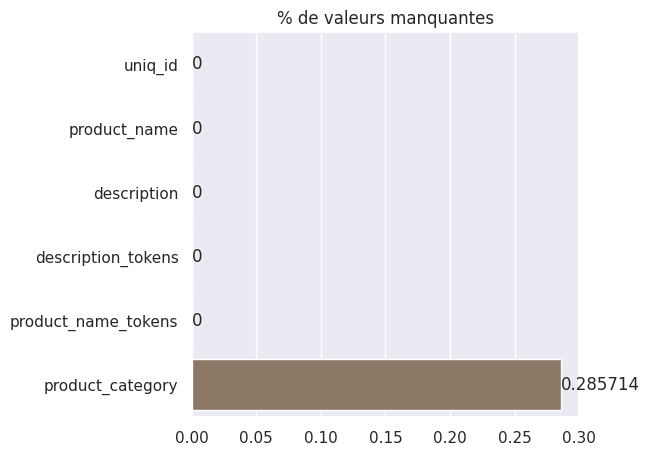

In [ ]:
plt.figure(figsize=(5, 5))
isna = (data.isna().sum().sort_values()/data.shape[0])*100
ax = sns.barplot(x=isna.values, y=isna.index)
for i in ax.containers:
  plt.bar_label(i, )
plt.title('% de valeurs manquantes')
plt.show()

Très peu de données manquantes : 0.28% pour product_category seulement .

In [ ]:
index = data.loc[data['product_category'].isna()].index
cat = [data.iloc[i, data.columns.get_loc('product_name')][-1] for i in index]
data.loc[data['product_category'].isna(), 'product_category'] = cat

In [ ]:
data.isna().sum().sum()

0

Valeurs aberrantes :     
 + Vérifier que les données sont bien des chaînes de caractères dans le bon alphabet.

In [ ]:
n_products = data.shape[0]
char = []
# chiffres pour les identifiants :
for i in range(48, 58):
  char.append(chr(i))
# minuscules
for i in range(97, 123):
  char.append(chr(i))
# Vérification
for var in ['uniq_id']:
  data = data.loc[data[var].astype(str).str[0].isin(char), :]
for var in  ['product_category']:
  data = data.loc[data[var].astype(str).str[1].isin(char), :]
for var in  ['product_name_tokens', 'description_tokens']:
  data = data.loc[data[var].astype(str).str[2].isin(char), :]

print(f"Nombre de lignes supprimées pendant le traitement : {n_products-data.shape[0]}")
print(f"Nouvelles dimensions : {data.shape}")

Nombre de lignes supprimées pendant le traitement : 3
Nouvelles dimensions : (1047, 6)


# Exploration des variables

1. Description et product_name

Longueurs maximales :
Descriptions=354 mots
Noms=20 mots


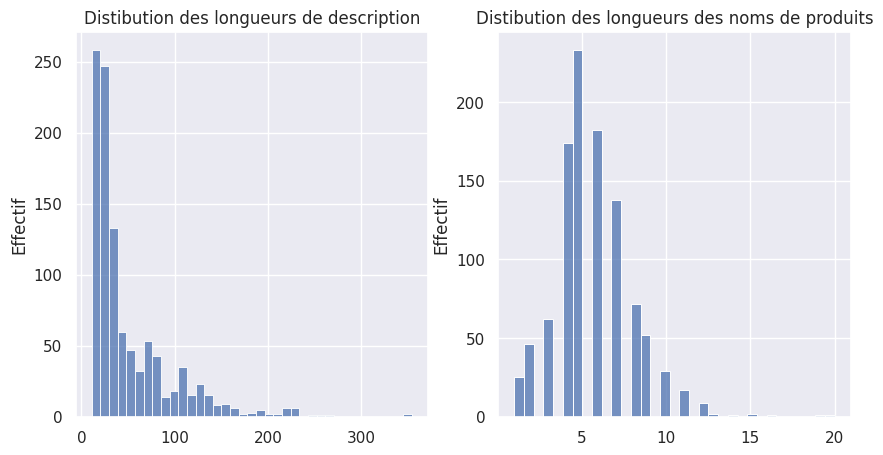

In [ ]:
len_description = [len(data.iloc[i, data.columns.get_loc('description_tokens')]) for i in range(data.shape[0])]
len_name = [len(data.iloc[i, data.columns.get_loc('product_name_tokens')]) for i in range(data.shape[0])]

print(f'Longueurs maximales :\nDescriptions={max(len_description)} mots\nNoms={max(len_name)} mots')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(len_description, ax=axs[0])
axs[0].set_title('Distibution des longueurs de description')
axs[0].set_ylabel('Effectif')

sns.histplot(len_name, ax=axs[1])
axs[1].set_title('Distibution des longueurs des noms de produits')
axs[1].set_ylabel('Effectif')

plt.show()

2.Target

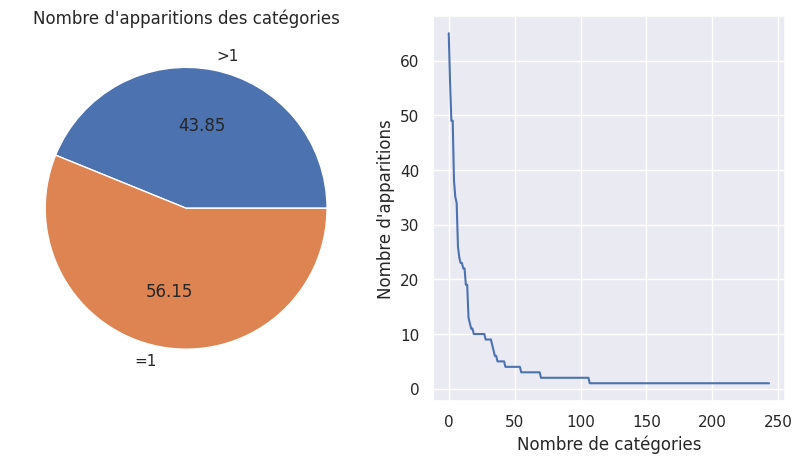

In [ ]:
tmp = data['product_category'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].pie([tmp[tmp>1].shape[0], tmp[tmp==1].shape[0]], labels=['>1', '=1'], autopct='%.2f')
axs[0].set_title("Nombre d'apparitions des catégories")

axs[1].plot(tmp.values)
axs[1].set_xlabel('Nombre de catégories')
axs[1].set_ylabel("Nombre d'apparitions")
plt.show()

Plus de la moitié des catégories présentes n'apparaissent qu'une seule fois : difficultés d'apprentissage ?

Les nombres d'apparition des catégories sont très déséquilibrés : de 1 à 65

In [ ]:
# Supprimer nombre apparition = 1
category_a_supp = tmp[tmp==1].index
data = data.loc[~data['product_category'].isin(category_a_supp)]
print(f"Nombre de catégories supprimées : {len(category_a_supp)}\nNombre de catégories restantes : {data['product_category'].nunique()}")
print(f"Nouvelles dimensions : {data.shape}")

Nombre de catégories supprimées : 137
Nombre de catégories restantes : 107
Nouvelles dimensions : (910, 6)


3. Corpus de description et de product_name

In [ ]:
corpus_description = "".join(sample.description.values)
corpus_name = "".join(sample.product_name.values)

corpus_description = corpus_description.lower().strip()
corpus_name = corpus_name.lower().strip()
print(f"Nombre de mots dans la variable description initiale: {len(corpus_description)}\nNombre de mots dans la variable product_name initiale: {len(corpus_name)}")

Nombre de mots dans la variable description initiale: 497512
Nombre de mots dans la variable product_name initiale: 47357


In [ ]:
lemmatizer = WordNetLemmatizer()

corpus_description = tokenize(corpus_description, min_lenght=3, no_numeric=True)
corpus_name = tokenize(corpus_name, min_lenght=3, no_numeric=True)

for i in range(len(corpus_description)):
  corpus_description[i] = lemmatizer.lemmatize(corpus_description[i])
for i in range(len(corpus_name)):
  corpus_name[i] = lemmatizer.lemmatize(corpus_name[i])

print(f"Nombre de tokens de description: {len(corpus_description)}\nNombre de tokens uniques de description: {len(set(corpus_description))}")
print(f"Nombre de tokens de product_name: {len(corpus_name)}\nNombre de tokens uniques de product_name: {len(set(corpus_name))}")

Nombre de tokens de description: 52659
Nombre de tokens uniques de description: 4551
Nombre de tokens de product_name: 5156
Nombre de tokens uniques de product_name: 1951


Supprimer les tokens qui n'apparaissent qu'une fois dans tout le corpus?

In [ ]:
rare_tokens_description = pd.Series(corpus_description).value_counts()[pd.Series(corpus_description).value_counts()==1].index
rare_tokens_name = pd.Series(corpus_name).value_counts()[pd.Series(corpus_name).value_counts()==1].index

rare_tokens = pd.DataFrame(rare_tokens_description[:10], columns=['description'])
rare_tokens['product_name'] = rare_tokens_name[:10]
rare_tokens

,description,product_name
0,gym,panda
1,module,one
2,lay,pleasing
3,ganeshabuy,cutlery
4,flamingo,funky
5,sunrise,plasticez
6,resistence,intensive
7,metalic,girlselantra
8,washspecifications,menfuncart
9,eternity,menmarvel


Ces mots peuvent être utiles pour identifier un produit, par exemple: 'cutlery' qui est une catégorie de produit.

On ne les supprime pas.

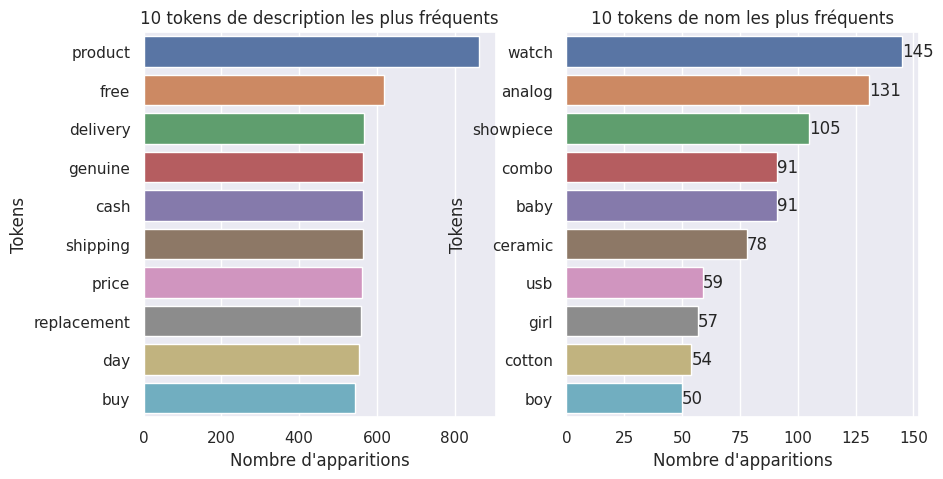

In [ ]:
frequent_tokens_description = pd.Series(corpus_description).value_counts()[:10]
frequent_tokens_name = pd.Series(corpus_name).value_counts()[:10]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(x=frequent_tokens_description.values, y=frequent_tokens_description.index, ax=axs[0])
for i in axs[0].containers:
  plt.bar_label(i, )
axs[0].set_title('10 tokens de description les plus fréquents')
axs[0].set_xlabel("Nombre d'apparitions")
axs[0].set_ylabel('Tokens')

sns.barplot(x=frequent_tokens_name.values, y=frequent_tokens_name.index, ax=axs[1])
for i in axs[1].containers:
  plt.bar_label(i, )
axs[1].set_title('10 tokens de nom les plus fréquents')
axs[1].set_xlabel("Nombre d'apparitions")
axs[1].set_ylabel('Tokens')

plt.show()

La variable product_name à l'air plus utile pour décrire les produits que la variable de description.

# Feature extraction : texte

Représentations creuses :

1. Bag-of-words

In [ ]:
# Pour mettre un texte dans le fit_transform faire "".rejoin() poir ne plus avoir de listes
data.reset_index(drop=True, inplace=True)
for i in data.index:
  data['description'][i] = " ".join(data['description_tokens'][i])
  data['product_name'][i] = " ".join(data['product_name_tokens'][i])

In [ ]:
vectorizer = CountVectorizer(lowercase=False)

X_d = vectorizer.fit_transform(data['description'])
bag_of_words_d = pd.DataFrame(X_d.toarray(), columns=vectorizer.get_feature_names_out())

X_n = vectorizer.fit_transform(data['product_name'])
bag_of_words_n = pd.DataFrame(X_n.toarray(), columns=vectorizer.get_feature_names_out())

bag_of_words_dn = pd.concat([bag_of_words_d, bag_of_words_n], axis=1)

print(f"Dimensions du bag_of_words de la feature de description : {bag_of_words_d.shape}")
print(f"Dimensions du bag_of_words de la feature de noms : {bag_of_words_n.shape}")
print(f"Dimensions des 2 combinés : {bag_of_words_dn.shape}")

Dimensions du bag_of_words de la feature de description : (910, 3544)
Dimensions du bag_of_words de la feature de noms : (910, 1448)
Dimensions des 2 combinés : (910, 4992)


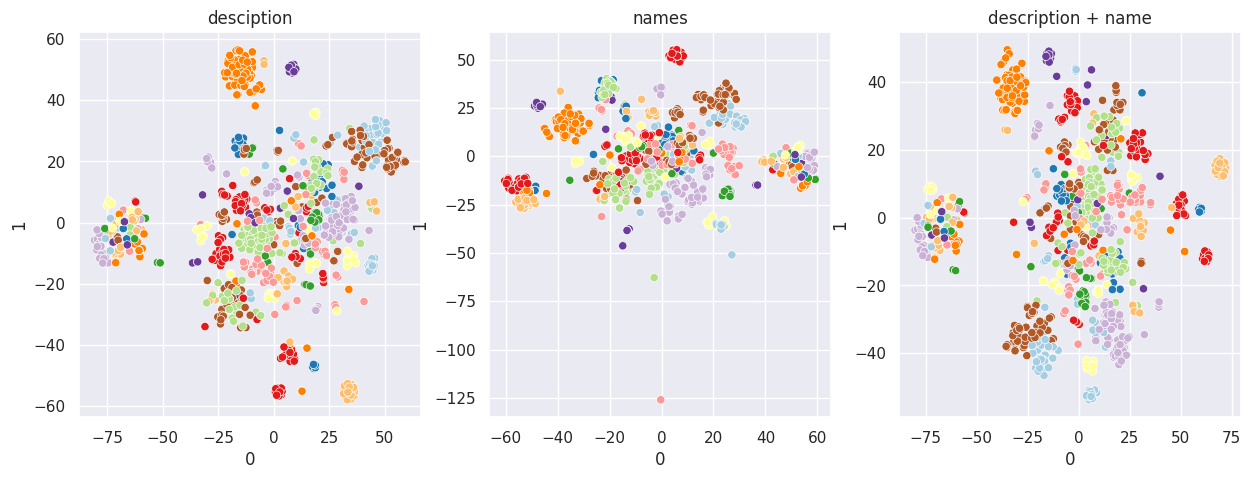

In [ ]:
# Visuaisation en 2D via t-SNE : hue=category
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# Projection 2D
bow_tsne_d = X_tsne(bag_of_words_d)
bow_tsne_n = X_tsne(bag_of_words_n)
bow_tsne_dn = X_tsne(bag_of_words_dn)
# scatterplot de la projection
plot_tsne(bow_tsne_d, data['product_category'], axs[0])
axs[0].set_title('desciption')
plot_tsne(bow_tsne_n, data['product_category'], axs[1])
axs[1].set_title('names')
plot_tsne(bow_tsne_dn, data['product_category'], axs[2])
axs[2].set_title('description + name')

plt.show()

Mauvaises séparations dans l'ensemble.

In [ ]:
# Tableau comparatif des scores ARI via fonction scores_ARI
comp_ARI = pd.DataFrame(scores_ARI(bow_tsne_d, bow_tsne_n, bow_tsne_dn), columns=['bag_of_words'], index=['description', 'product_name', 'both'])
comp_ARI

,bag_of_words
description,0.353680
product_name,0.379367
both,0.416806


Il y a un meilleur clustering sur la combinaison des descriptions et noms.

Confirmation que les résultats dans l'ensemble sont mauvais.

2. Tf_Idf

In [ ]:
tfidf = TfidfVectorizer(lowercase=False)

X_d = tfidf.fit_transform(data['description'])
tfidf_d = pd.DataFrame(X_d.toarray(), columns=tfidf.get_feature_names_out())

X_n = tfidf.fit_transform(data['product_name'])
tfidf_n = pd.DataFrame(X_n.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_dn = pd.concat([tfidf_d, tfidf_n], axis=1)

print(f"Dimensions du tf-idf de la feature de description : {tfidf_d.shape}")
print(f"Dimensions du tf-idf de la feature de noms : {tfidf_n.shape}")
print(f"Dimensons des deux combinés : {tfidf_dn.shape}")

Dimensions du tf-idf de la feature de description : (910, 3544)
Dimensions du tf-idf de la feature de noms : (910, 1448)
Dimensons des deux combinés : (910, 4992)


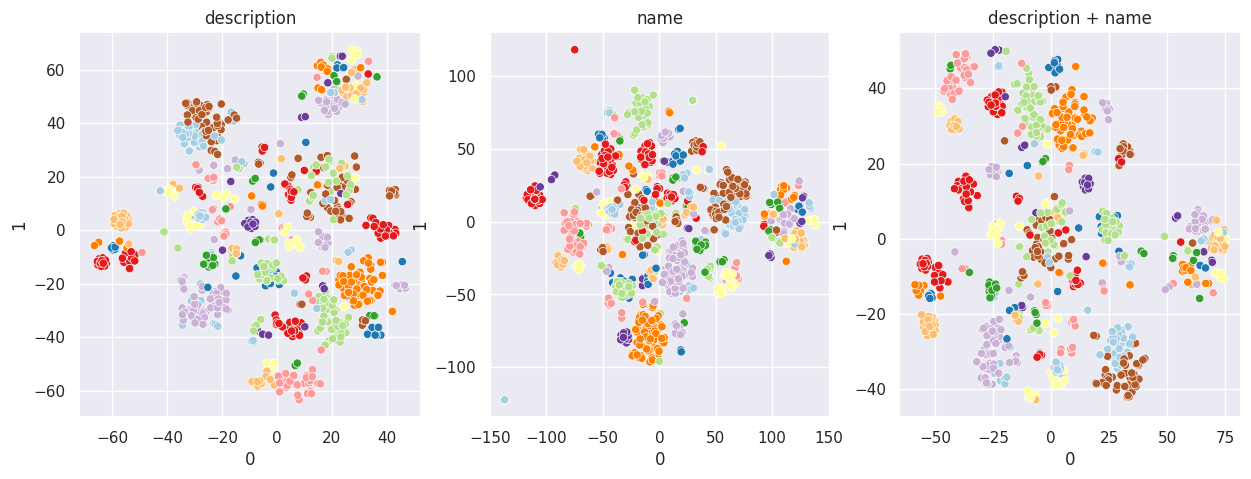

In [ ]:
# Visuaisation en 2D via t-SNE
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

tfidf_tsne_d = X_tsne(tfidf_d)
tfidf_tsne_n = X_tsne(tfidf_n)
tfidf_tsne_dn = X_tsne(tfidf_dn)

plot_tsne(tfidf_tsne_d, data['product_category'], ax=axs[0])
axs[0].set_title('description')
plot_tsne(tfidf_tsne_n, data['product_category'], ax=axs[1])
axs[1].set_title('name')
plot_tsne(tfidf_tsne_dn, data['product_category'], ax=axs[2])
axs[2].set_title('description + name')

plt.show()

La segmentation est mauvaise en général.

In [ ]:
comp_ARI['Tf-Idf'] = scores_ARI(tfidf_tsne_d, tfidf_tsne_n, tfidf_tsne_dn)

comp_ARI

,bag_of_words,Tf-Idf
description,0.353680,0.394691
product_name,0.379367,0.394503
both,0.416806,0.499142


Il y a toujours un meilleur clustering avec la combinaison des descriptions et noms.

D'après les scores ARI, l'approche Tf-Idf est plus performante que bag of words.

Si on venait à utiliser une représentation creuse, il faudrait choisir : Tf-Idf appliqué sur les deux variables description et product_name.

__________________________________________________________________
Représentations denses :     
1. Doc2Vec

In [ ]:
# Liste des 108 catégories restantes
cat = data['product_category'].unique()

# 1 tagged document par ligne (906 docs)
documents_d = [TaggedDocument(x,[i]) for i,x in enumerate(list(data['description_tokens']))]
documents_n = [TaggedDocument(x,[i]) for i,x in enumerate(list(data['product_name_tokens']))]
#Vocabulaire et training
d2v_d = Doc2Vec()
d2v_n = Doc2Vec()

d2v_d.build_vocab(documents_d)
d2v_n.build_vocab(documents_n)

d2v_d.train(documents_d, total_examples=d2v_d.corpus_count, epochs=d2v_d.epochs)
d2v_n.train(documents_n, total_examples=d2v_n.corpus_count, epochs=d2v_n.epochs)
# Feature engineering : 1 feature pour chaque catégorie
for i,e in enumerate(cat):
  # Liste des tokens présents dans les descriptions correspondants à la catégorie cat[i]
  cat_tokens_d = flatten(list(data.loc[data['product_category']==cat[i], 'description_tokens']))
  # Vecteur représentant la liste de tokens précédents
  cat_vector_d = d2v_d.infer_vector(cat_tokens_d)
  # Similarité entre le vecteur de la description et le vecteur des descriptions de la catégorie (cos entre les 2 vecteurs)
  data["doc2vec_d_"+str(e)] = data["description_tokens"].apply(lambda x  :  cosine(d2v_d.infer_vector(x),cat_vector_d))
  # Pour éviter d'avoir un DataFrame fragmenté:
  data = data.copy()
features_d2v_d = data.iloc[:, -107:]

# Pareil pour 'product_name'
for i,e in enumerate(cat):
  cat_tokens_n = flatten(list(data.loc[data['product_category']==cat[i], 'product_name_tokens']))
  cat_vector_n = d2v_n.infer_vector(cat_tokens_n)
  data["doc2vec_n_"+str(e)] = data["product_name_tokens"].apply(lambda x  :  cosine(d2v_n.infer_vector(x),cat_vector_n))
  data = data.copy()
features_d2v_n = data.iloc[:, -107:]

# Combinaison des 2
features_d2v_dn = pd.concat([features_d2v_d, features_d2v_n], axis=1)

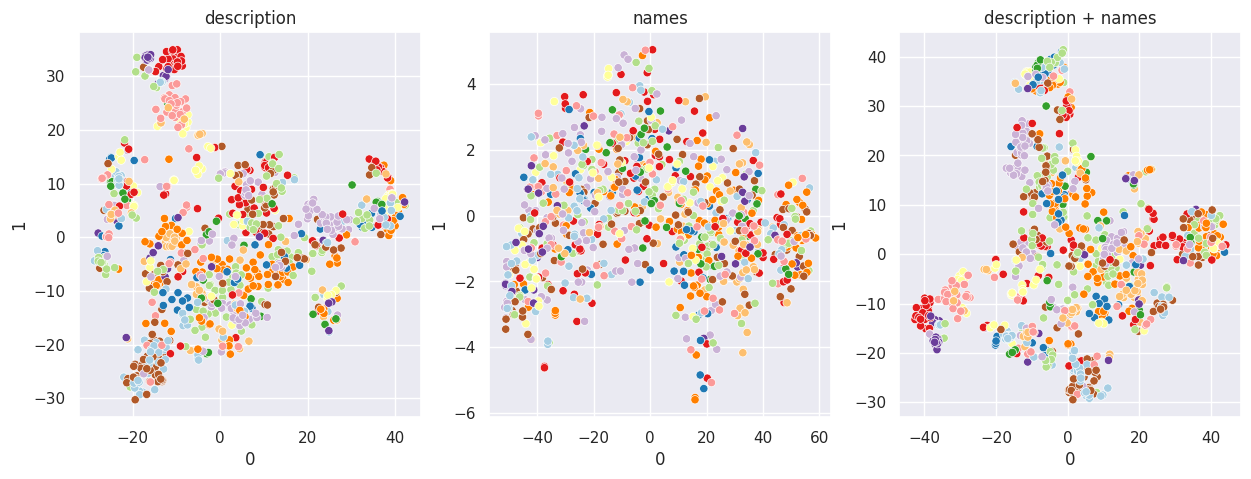

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

doc2vec_tsne_d = X_tsne(features_d2v_d)
doc2vec_tsne_n = X_tsne(features_d2v_n)
doc2vec_tsne_dn = X_tsne(features_d2v_dn)

plot_tsne(doc2vec_tsne_d, data['product_category'], ax=axs[0])
axs[0].set_title('description')
plot_tsne(doc2vec_tsne_n, data['product_category'], ax=axs[1])
axs[1].set_title('names')
plot_tsne(doc2vec_tsne_dn, data['product_category'], ax=axs[2])
axs[2].set_title('description + names')

plt.show()

Il n'y a presque aucun cluster visible.

In [ ]:
comp_ARI['Doc2Vec'] = scores_ARI(doc2vec_tsne_d, doc2vec_tsne_n, doc2vec_tsne_dn)
comp_ARI

,bag_of_words,Tf-Idf,Doc2Vec
description,0.353680,0.394691,0.193887
product_name,0.379367,0.394503,0.031376
both,0.416806,0.499142,0.155519


Confirmation des observations du t-SNE, le regroupement par catégorie fonctionne mal après utilisation de Doc2Vec. L'échantillon ne doit pas être assez conséquent pour obtenir une bonne compréhension des contextes.

On supprime les features doc2vec_ dans data :

In [ ]:
data = data.iloc[:, :6]

2. BERT : https://www.sbert.net/

In [ ]:
sent_trans_model = SentenceTransformer("all-mpnet-base-v2")
bert_vectors_d = sent_trans_model.encode(data['description'])
bert_vectors_n = sent_trans_model.encode(data['product_name'])
bert_vectors_dn = pd.concat([pd.DataFrame(bert_vectors_d), pd.DataFrame(bert_vectors_n)], axis=1)

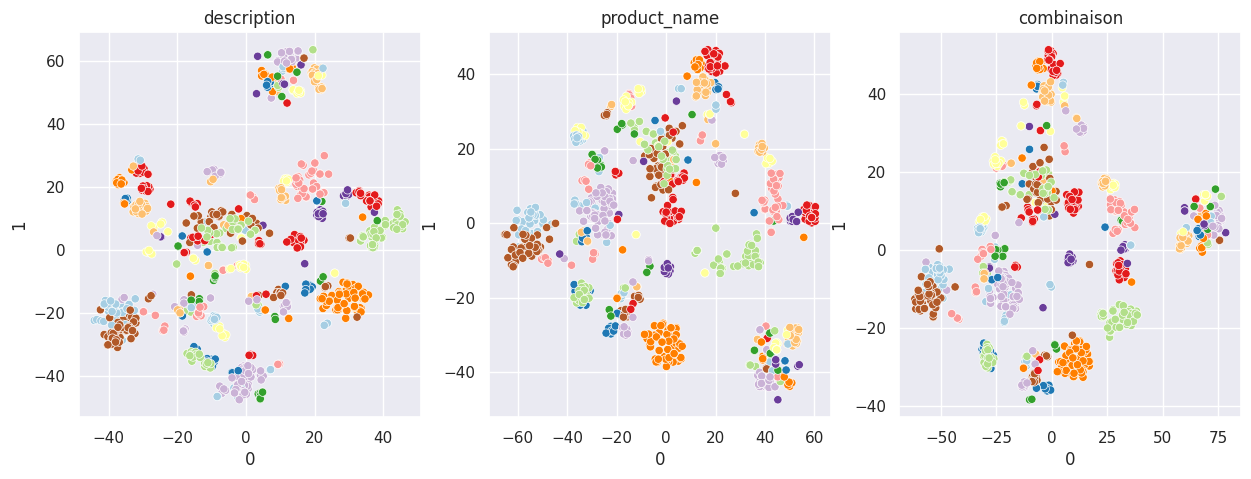

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

bert_tsne_d = X_tsne(bert_vectors_d)
bert_tsne_n = X_tsne(bert_vectors_n)
bert_tsne_dn = X_tsne(bert_vectors_dn)

plot_tsne(bert_tsne_d, data['product_category'], axs[0])
axs[0].set_title('description')
plot_tsne(bert_tsne_n, data['product_category'], axs[1])
axs[1].set_title('product_name')
plot_tsne(bert_tsne_dn, data['product_category'], axs[2])
axs[2].set_title('combinaison')

plt.show()

In [ ]:
comp_ARI['S-BERT'] = scores_ARI(bert_tsne_d, bert_tsne_n, bert_tsne_dn)

comp_ARI

,bag_of_words,Tf-Idf,Doc2Vec,S-BERT
description,0.353680,0.394691,0.193887,0.379821
product_name,0.379367,0.394503,0.031376,0.403249
both,0.416806,0.499142,0.155519,0.479363


BERT à peine plus performant que Tf-Idf. On utilise l'avant dernière couche d'un modèle BERT au lieu de Sentence Transformer pour la prochaine extraction de features :

3bis. BERT uncased

In [ ]:
def bert_inp(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        # Préparation des textes :
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot

def feature_BERT(model, model_type, sentences, max_length, b_size) :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp(sentences[idx:idx+batch_size],
                                                                           bert_tokenizer, max_length)

        outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
        last_hidden_states = outputs.last_hidden_state

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    return features_bert, last_hidden_states_tot

In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)

sentences_d = data['description'].to_list()
sentences_n = data['product_name'].to_list()
sentences_dn = sentences_d + sentences_n

features_bert_d, last_hidden_states_tot_d = feature_BERT(model, model_type, sentences_d,
                                                         max_length, batch_size)
features_bert_n, last_hidden_states_tot_n = feature_BERT(model, model_type, sentences_n,
                                                         max_length, batch_size)
features_bert_dn, last_hidden_states_tot_dn = feature_BERT(model, model_type, sentences_dn,
                                                           max_length, batch_size)

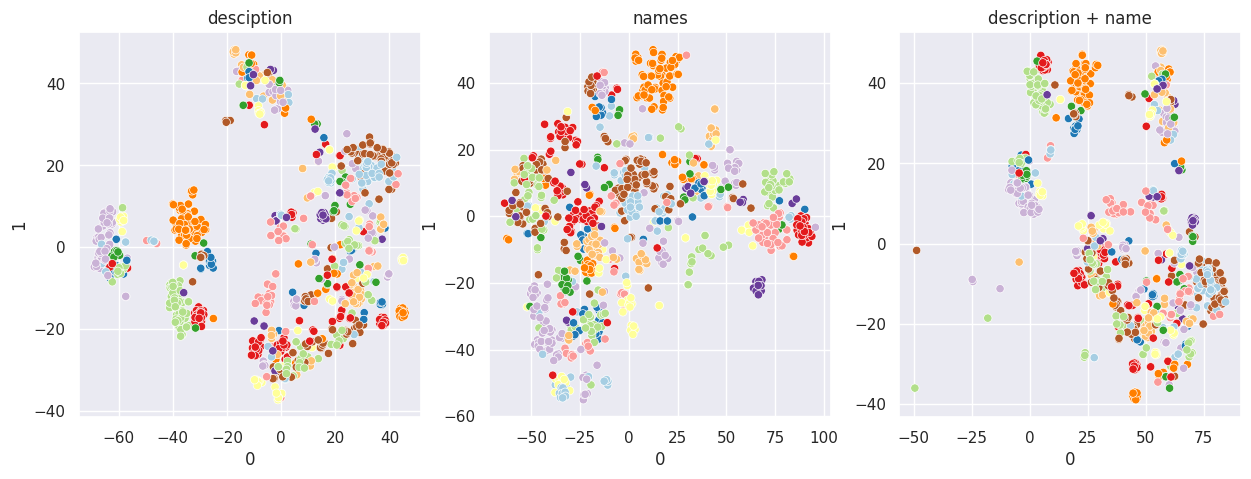

In [ ]:
bert2_tsne_d = X_tsne(features_bert_d)
bert2_tsne_n = X_tsne(features_bert_n)
bert2_tsne_dn = X_tsne(features_bert_dn)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plot_tsne(bert2_tsne_d, data['product_category'], axs[0])
axs[0].set_title('desciption')
plot_tsne(bert2_tsne_n, data['product_category'], axs[1])
axs[1].set_title('names')
plot_tsne(bert2_tsne_dn, data['product_category'], axs[2])
axs[2].set_title('description + name')

plt.show()

In [ ]:
comp_ARI['BERT base/uncased'] = scores_ARI(bert2_tsne_d, bert2_tsne_n, bert2_tsne_dn)

comp_ARI

,bag_of_words,Tf-Idf,Doc2Vec,S-BERT,BERT base/uncased
description,0.353680,0.394691,0.193887,0.379821,0.316721
product_name,0.379367,0.394503,0.031376,0.403249,0.318048
both,0.416806,0.499142,0.155519,0.479363,0.388138


Moins performant que S-BERT...

3.USE

In [ ]:
use_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
# np.array car pd.DataFrame ne prend pas des objets en 3D
use_vectors_d = np.array([use_embed([doc]).numpy() for doc in data['description']])
# On peut retransformer en DataFrame après utilisation de np.squeeze pour repasser en 2D
use_vectors_d = pd.DataFrame(np.squeeze(use_vectors_d))

use_vectors_n = np.array([use_embed([doc]).numpy() for doc in data['product_name']])
use_vectors_n = pd.DataFrame(np.squeeze(use_vectors_n))

use_vectors_dn = pd.concat([use_vectors_d, use_vectors_n], axis=1)

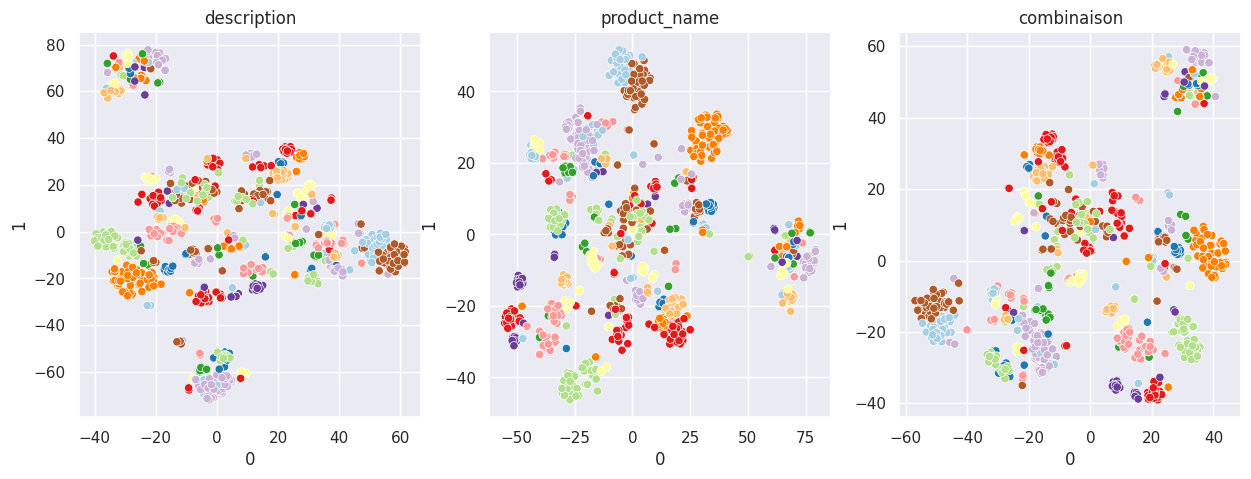

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

use_tsne_d = X_tsne(use_vectors_d)
use_tsne_n = X_tsne(use_vectors_n)
use_tsne_dn = X_tsne(use_vectors_dn)

plot_tsne(use_tsne_d, data['product_category'], axs[0])
axs[0].set_title('description')
plot_tsne(use_tsne_n, data['product_category'], axs[1])
axs[1].set_title('product_name')
plot_tsne(use_tsne_dn, data['product_category'], axs[2])
axs[2].set_title('combinaison')

plt.show()

In [ ]:
comp_ARI['USE'] = scores_ARI(use_tsne_d, use_tsne_n, use_tsne_dn)

comp_ARI

,bag_of_words,Tf-Idf,Doc2Vec,S-BERT,BERT base/uncased,USE
description,0.353680,0.394691,0.193887,0.379821,0.316721,0.360705
product_name,0.379367,0.394503,0.031376,0.403249,0.318048,0.392939
both,0.416806,0.499142,0.155519,0.479363,0.388138,0.446770


On n'a pas réussi à faire mieux que Tf-Idf, pourtant un modèle assez simple.

Comparaison de toutes les méthodes de feature extraction et des variables utilisées :

In [ ]:
comp_ARI['Best Model'] = np.zeros(3)
for i, ind in enumerate(list(comp_ARI.index)):
  comp_ARI['Best Model'][i] = comp_ARI.loc[ind, comp_ARI.loc[ind, :]==max(comp_ARI.loc[ind, :])].index.values[0]

comp_ARI

,bag_of_words,Tf-Idf,Doc2Vec,S-BERT,BERT base/uncased,USE,Best Model
description,0.353680,0.394691,0.193887,0.379821,0.316721,0.360705,Tf-Idf
product_name,0.379367,0.394503,0.031376,0.403249,0.318048,0.392939,S-BERT
both,0.416806,0.499142,0.155519,0.479363,0.388138,0.446770,Tf-Idf


In [ ]:
best_feature_s = [comp_ARI.loc[comp_ARI.loc[:, model]==max(comp_ARI.loc[:, model]), model].index.values[0] for model in comp_ARI.columns[:-1]]
best_feature_s.append('None')
best_feature_s = pd.DataFrame(best_feature_s, columns=['Best feature(s)'], index=comp_ARI.columns).transpose()
comp_ARI = pd.concat([comp_ARI, best_feature_s], axis=0)
comp_ARI

,bag_of_words,Tf-Idf,Doc2Vec,S-BERT,BERT base/uncased,USE,Best Model
description,0.35368,0.394691,0.193887,0.379821,0.316721,0.360705,Tf-Idf
product_name,0.379367,0.394503,0.031376,0.403249,0.318048,0.392939,S-BERT
both,0.416806,0.499142,0.155519,0.479363,0.388138,0.44677,Tf-Idf
Best feature(s),both,both,description,both,both,both,None


Le modèle utilisé pour la feature extraction qui fonctionne le mieux est Tf-Idf sur les variables description et product_name.

# Imports

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import cluster

import tensorflow as tf
from keras.utils import load_img, img_to_array
from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.models import Model

from glob import glob
from sklearn import manifold, decomposition

In [ ]:
'''
Prétraitement des images
'''
def process_img(img):
  img = cv2.equalizeHist(img)
  img = cv2.GaussianBlur(img, (3,3), 0)
  return img
'''
Nouvelle fonction de clustering + ARI
'''
def score_ARI(tsne_features):
  km = KMeans(n_clusters=data2['product_category'].nunique(), n_init='auto')
  km.fit(tsne_features)
  score = adjusted_rand_score(data2['category_labels'], km.labels_)
  return score

Par souci de mémoire le passage en gris à été supprimé de la fonction de prétraitement pour être placé directement dans la fonction d'import imread()

In [ ]:
# Import et stockage de toutes les photos
data2 = pd.DataFrame(sample[['uniq_id', 'image']])

data2['product_category'] = sample['product_category_tree'].str.split('"', expand=True)[1].str.split(">>", expand=True)[2].str.lower()

data2.rename({'image' : 'image_name'}, axis=1, inplace=True)
# Passage en gris : La session a planté plusieurs fois lors du traitement des images, on passe en gris pour utiliser moins de mémoire.
images_grey = []
with tf.device('/gpu:0'):
  for i in data2.index:
    images_grey.append(cv2.imread('/content/drive/MyDrive/Colab Notebooks/Projet 6/Images/'+ str(data2.iloc[i, data2.columns.get_loc('image_name')]),
                       cv2.IMREAD_GRAYSCALE))
data2['images_grey'] = images_grey

In [ ]:
le = LabelEncoder()
le.fit(data2['product_category'])
data2['category_labels'] = le.transform(data2['product_category'])

In [ ]:
data2.head(2)

,uniq_id,image_name,product_category,images_grey,category_labels
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,curtains,"[[185, 185, 186, 186, 186, 185, 184, 184, 185,...",65
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby bath towels,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",9


# EDA

Image :

Taille de la matrice de pixels : (510, 318)


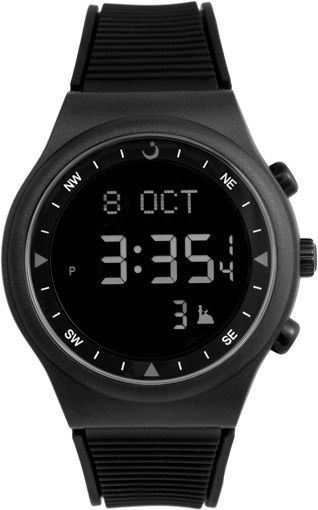

In [ ]:
# On prend une image seule
img = data2.iloc[8, data2.columns.get_loc('images_grey')]

print("Taille de la matrice de pixels : {}".format(img.shape))
cv2_imshow(img)

On est bien en 2D : pas de codage sur 3*8 bits pour la couleur.

Images:

 curtains 


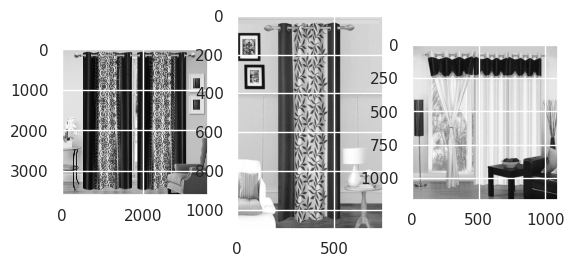

 baby bath towels 


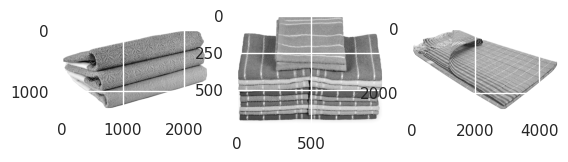

 bedsheets 


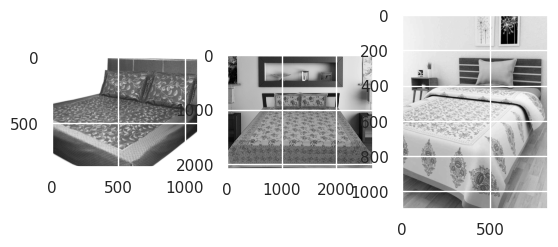

In [ ]:
# Liste exhaustive des catégories
cat_list = data2.product_category.unique()
# Images correspondantes aux 3 premières catégories
list_0=[data2['images_grey'][i] for i in range(len(data2)) if data2['product_category'][i]==cat_list[0]]
list_1=[data2['images_grey'][i] for i in range(len(data2)) if data2['product_category'][i]==cat_list[1]]
list_2=[data2['images_grey'][i] for i in range(len(data2)) if data2['product_category'][i]==cat_list[2]]
# Affichage des 3 premières images des 3 premières catégories
for name, list_ in enumerate([list_0, list_1, list_2]):
  print(cat_list[name])
  for i in range(3):
    plt.subplot(131 + i)
    plt.imshow(list_[i], cmap='gray', vmin=0, vmax=255)
  plt.show()

# Prétraitement des images

Essai avec une seule photo pour tester les effets des fonction de preprocessing:

Contraste :

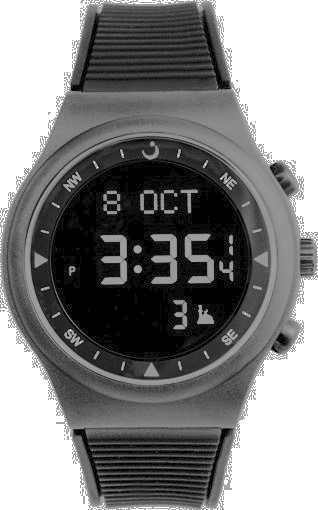

In [ ]:
cv2_imshow(cv2.equalizeHist(img))

Le traitement n'empêche pas de reconnaître le produit : à l'inverse du traitement du contraste via le module PIL (on garde cv2)

Filtrage du bruit :

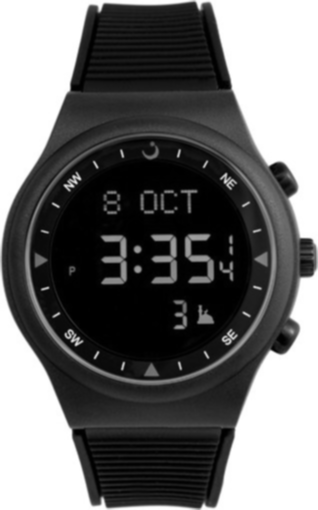

In [ ]:
cv2_imshow(cv2.GaussianBlur(img, (3,3), 0))

Le floutage venant du filtrage du bruit a été minimisé en choisissant un  paramètre (3, 3) pour la taille du noyau.

Fonction de prétraitement retenue (contraste + filtrage du bruit):

In [ ]:
# Besoin de trop de RAM si fait d'un coup : data2.images = [process_img(img) for img in data2.images]
data2['images_grey'] = data2['images_grey'].apply(lambda x: process_img(x))

# Feature extraction : images

1. ORB

Taille du descripteur :  (500, 32)


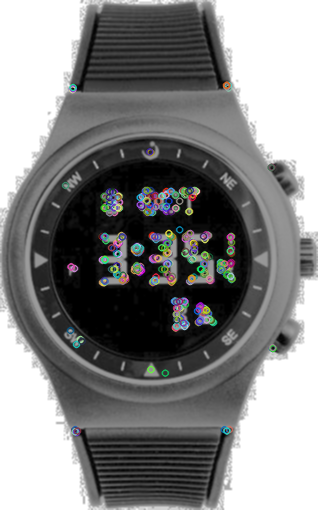

In [ ]:
# Test
img = data2.iloc[8, data2.columns.get_loc('images_grey')]

orb=cv2.ORB_create()
kp, des = orb.detectAndCompute(img, None)
img_kp = cv2.drawKeypoints(img, kp, img)

print("Taille du descripteur : ", des.shape)
cv2_imshow(img_kp)

In [ ]:
# 1050 descripteurs de dimensions : (Nombre de KeyPoints, 32)
descriptors = np.asarray([orb.detectAndCompute(img, None)[1] for img in data2.images_grey], dtype=object)
descriptors.shape

(1050,)

In [ ]:
# Chercher la dimension maximum : les descripteurs n'ont pas tous le même nbre de keypoints
nb_features_max = 0
for descriptor in descriptors:
  if descriptor.shape[0] > nb_features_max:
    nb_features_max = descriptor.shape[0]
# On transforme les arrays des descripteurs en vecteurs
des_vectors = [des.reshape(1,-1) for des in descriptors]

print(f"Nombre de features max d'un descriptor: {nb_features_max}\nDimensions des vecteurs :")
tailles = [des_vectors[i].shape[1] for i in range(len(des_vectors))]
pd.Series(tailles).value_counts().sort_values(ascending=False)

Nombre de features max d'un descriptor: 920
Dimensions des vecteurs :


16000    937
16032     13
14944      4
8064       4
16128      3
        ... 
12800      1
12576      1
14464      1
13440      1
16960      1
Length: 74, dtype: int64

Les tailles des vecteurs sont hétérogènes : on rajoute à tous les descripteurs de taille inférieure à 920 (maximum) des pixels noirs pour homogénéiser les dimensions (clustering impossible sinon).

In [ ]:
# Homogénéisation des tailles des vecteurs
vectors = []
for des in des_vectors:
  # Après vectorisation via .reshape() le nombre de features a été multiplié par 32
  if des.shape[0] <= nb_features_max*32:
    # Si la taille est inférieure à la taille maxi : ajouter des pixels noirs
    vectors.append(np.hstack([des.reshape(1,-1),
                   np.zeros(nb_features_max*32 - des.shape[1]).reshape(1,-1)]))
  else:
    vectors.append(des)

print(f"Nombre de vecteurs : {len(vectors)}\nDimension de chaque vecteur : {vectors[0].shape}")
orb_features = np.vstack(vectors)
print(f'Nombre de features finales: {orb_features.shape[1]}')

Nombre de vecteurs : 1050
Dimension de chaque vecteur : (1, 29440)
Nombre de features finales: 29440


T-SNE et clustering :

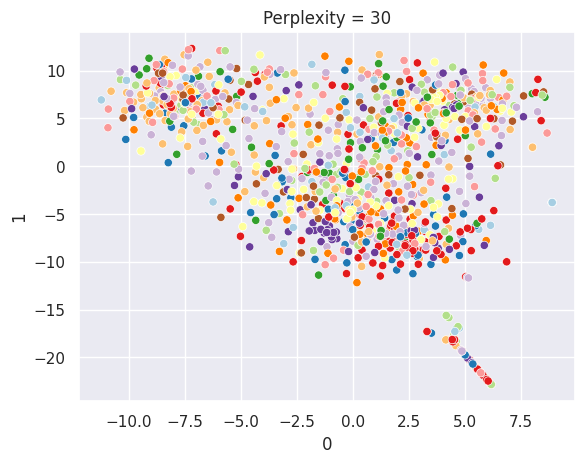

In [ ]:
orb_tsne = X_tsne(orb_features)
fig, ax = plt.subplots()
plot_tsne(orb_tsne, data2.product_category, ax)

Très mauvais regroupement des catégories. : aucun cluster visible.

In [ ]:
comp_ARI2 = pd.DataFrame(score_ARI(orb_tsne), index=['images'], columns=['ORB'])
comp_ARI2

,ORB
images,0.027501


2. ORB2 : sans ajout de pixels noirs

Au lieu d'homogénéiser les descripteurs pour les séparer en clusters on effectue un clustering sur les keypoints.

In [ ]:
orb_keypoints = []
orb = cv2.ORB_create(500)

for img in data2.images_grey:
  kp, des = orb.detectAndCompute(img, None)
  orb_keypoints.append(des)

orb_keypoints_by_img = np.asarray(orb_keypoints, dtype=object)
orb_keypoints_all = np.concatenate(orb_keypoints_by_img, axis=0)

print("Nombre de keypoints : ", orb_keypoints_all.shape)

Nombre de keypoints :  (519864, 32)


In [ ]:
# Clustering des keypoints
k = int(round(np.sqrt(len(orb_keypoints_all)),0))
print("Nombre de clusters de descripteurs estimés : ", k)

kmeans = cluster.MiniBatchKMeans(n_clusters=k, n_init='auto')
kmeans.fit(orb_keypoints_all)

Nombre de clusters de descripteurs estimés :  721


MiniBatchKMeans(init_size=2163, n_clusters=721, n_init='auto', random_state=0)

In [ ]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist
# Vecteurs avec le nombre de keypoints attribués à chaque clusters
count_vectors = []
for i, image_desc in enumerate(orb_keypoints_by_img) :
    hist = build_histogram(kmeans, image_desc, i)
    count_vectors.append(hist)

im_features = np.asarray(count_vectors)

Le cluster à attribuer à un descripteur est trouvé en regardant le clustering de ses keypoints.

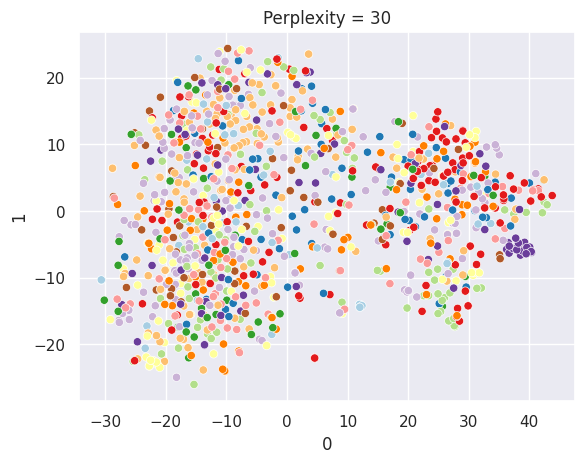

In [ ]:
orb2_tsne = X_tsne(im_features)
fig, ax = plt.subplots()
plot_tsne(orb2_tsne, data2.product_category, ax)

1 seul cluster visible et très mal séparés des autres points.

In [ ]:
comp_ARI2['ORB2'] = score_ARI(orb2_tsne)
comp_ARI2

,ORB,ORB2
images,0.027501,0.043345


Score ARI doublé mais toujours très faible.

2. CNN Transfer Learning

Le traitement des images est différent pour VGG16 : import des images d'origine en couleur.

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Projet 6/Images/'

data_path = glob(path+'*.jp*')

def data_fct(path) :
    list_photos = [file for file in path]
    print(len(list_photos))
    data3 = pd.DataFrame()
    data3["image_path"] = list_photos
    data3["image_name"] = pd.Series(list_photos).str.split('/', expand=True)[7]
    data3["label_name"] = data3.merge(data, on='image_name', how='left').loc[:, 'product_category']
    return data3

data3 = data_fct(data_path)

le = preprocessing.LabelEncoder()
le.fit(data3["label_name"])
data3["label"] = le.transform(data3["label_name"])
# data.head(5)
data3.head(5)

1050


,image_path,image_name,label_name,label
0,/content/drive/MyDrive/Colab Notebooks/Projet ...,00e966a5049a262cfc72e6bbf68b80e7.jpg,cases & covers,46
1,/content/drive/MyDrive/Colab Notebooks/Projet ...,00ed03657cedbe4663eff2d7fa702a33.jpg,usb gadgets,231
2,/content/drive/MyDrive/Colab Notebooks/Projet ...,02127f52e96fb72c66bf081d25104ef8.jpg,prithish coffee mugs,178
3,/content/drive/MyDrive/Colab Notebooks/Projet ...,00cbbc837d340fa163d11e169fbdb952.jpg,table runners,218
4,/content/drive/MyDrive/Colab Notebooks/Projet ...,00d84a518e0550612fcfcba3b02b6255.jpg,mxofere combos and kits,149


In [ ]:
count = data3['label'].value_counts()
count[count==1]

146    1
142    1
133    1
143    1
70     1
      ..
172    1
130    1
93     1
68     1
7      1
Name: label, Length: 137, dtype: int64

137 catégories n'apparaissent qu'une seule fois : suppression pour les mêmes raisons que la classification précédente.

In [ ]:
data3 = data3.loc[~data3['label'].isin(count[count==1].index), :]
data3['label'].value_counts()

72     65
32     56
14     49
190    49
231    38
       ..
202     2
74      2
0       2
136     2
83      2
Name: label, Length: 108, dtype: int64

Modèle de base VGG16 entrîné sur le dataset ImageNet.

Comme pour BERT on récupère les features sur les couches intermédiaires (l'avant-dernière ici)

In [ ]:
base_model = vgg16.VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Extraction des features VGG16 :


On contourne le problème de mémoire précédent en ne stockant que les array des images traitées (variable temporaire img).

On n'utilise pas la fonction de prétraitement créer dans ce notebook, le module vgg16 à une fonction preprocess_input() adaptée à notre modèle.

In [ ]:
images_features = []
i=0
for image_file in data3["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = vgg16.preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0])

images_features = np.asarray(images_features)
images_features.shape

600
700
800
900


(913, 4096)

Première réduction de dimensions pour faciliter TSNE (4096 features) :

In [ ]:
print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(913, 4096)
(913, 703)


2e réduction de dimensions : projection 2D tsne

In [ ]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000)
X_tsne = tsne.fit_transform(feat_pca)

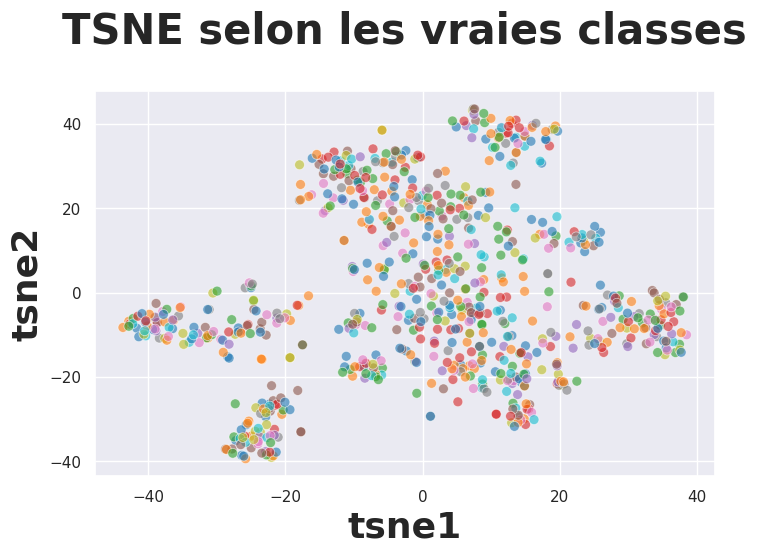

In [ ]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data3["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=df_tsne['class'].nunique()),
    data=df_tsne,
    legend=None)

plt.xlabel('tsne1')
plt.ylabel('tsne2')

plt.show()

On peut voir une amélioration par rapport à ORB.

Ajustement du nombre de clusters pour KMeans :

In [ ]:
ari_pca_tsne = []

for n_clusters in range(1, data3.label.nunique()+1):
  cls = cluster.KMeans(n_clusters=n_clusters, n_init='auto')
  cls.fit(X_tsne)
  ari_pca_tsne.append([n_clusters, metrics.adjusted_rand_score(data3.label, cls.labels_)])

ARIs = pd.DataFrame(ari_pca_tsne)
print(f"ARI maximal pour n_clusters = {ARIs.loc[ARIs[1]==np.max(ARIs[1]), 0].values[0]}")

ARI maximal pour n_clusters = 36


In [ ]:
comp_ARI2['VGG16'] = np.max(ARIs[1])

comp_ARI2

,ORB,ORB2,VGG16
images,0.027501,0.043345,0.376111


La classification automatique des produits à l'aide des images paraît moins performante que celle à l'aide des textes : l'ARI maximal passe de 0.5 pour Tf-Idf à 0.38 pour VGG16.

Pour la classification à partir des images :

Seul VGG16 montre des résultats moyens mais ces résultats sont obtenus sur un modèle de base, sans ajout de couches et non entraîné sur nos données : il y a une marge d'optimisation non négligeable.